<a href="https://colab.research.google.com/github/RafaelVendiciano/Portfolio/blob/master/Avalia%C3%A7%C3%A3o_de_Risco_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação de Risco de Crédito


Uma das área que causa mais problemas para bancos, financiadoras e empresários é a taxa de inadimplência por parte da sua carteira de clientes.

Avaliar se uma pessoa irá deixar de cumprir com suas obrigações financeiras é de extrema importância, e pode causar um grande impacto no balanço da Instituição. Cada vez mais, soluções vêm sendo desenvolvidas e aprimoradas visando minimizar o risco de *default*. 

*Default* é o termo utilizado para indicar o não cumprimento das obrigações e/ou condições de um empréstimo (como financiamentos ou dívidas de cartão de crédito). Normalmente, o principal motivo para o descumprimento das condições de pagamento é incapacidade financeira do cliente.

<p align=center>
  <img src="http://sigmoidal.ai/wp-content/uploads/2019/10/2940191.jpg" height="300px">
</p>
 
Grandes bancos e Fintechs têm apostado cada vez mais em modelos de *Machine Learning* para previnir a inadimplência de alguns clientes.

Dentre as principais instituições financeira, o [Nubank](https://nubank.com.br/sobre-nos) é uma das que mais tem se destacado no uso de Inteligência Artificial e times de *Data Science*.

O conjunto de dados a ser utilizado neste Projeto de *Data Science* parte de uma competição realizada pela Startup [Nubank](https://nubank.com.br/sobre-nos) a fim de revelar talentos e potenciais contratações pela Fintech.

## Contextualização do Problema

Neste problema, o objetivo é prever qual a probabilidade de um cliente da Startup Nubank não coumprir com suas obrigações financeiras e deixar de pagar a sua fatura do Cartão de Crédito.

<p align=center>
<img src="http://sigmoidal.ai/wp-content/uploads/2019/10/Nubank_logo.png" width="90px"></p>
  
Vale ressaltar que essa avaliação deve ser realizada no momento em que o cliente solicita o cartão (normalmente no primeiro contato com a instituição).



> OBJETIVO: Criar um modelo que retorne com boa assertividade se um cliente irá virar inadimplente.

## Importar os Dados

Os dados que serão utilizados nesta análise estão disponíveis para download por meio [deste link](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0). Consiste basicamente em um arquivo `csv` contendo 45.000 entradas e 43 colunas.

Este arquivo será importando para uma estrutura *DataFrame* utilizando a biblioteca `pandas` a fim de possibilitar sua manipulação e análise.

In [1]:
# importar os pacotes necessários
!pip install scikit-plot -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# definir o estilo do seaborn para os plots
sns.set_style()

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore');

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv("http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0")

## Análise Exploratória de Dados

A primeira coisa que faremos após importar o *dataset* será examinar as dimensões do *DataFrame* e as primeiras entradas. Isso possibilitará criar uma consciência situacional inicial a respeito do formato de entrada e da estrutura geral dos dados.

Em relação à **dimensionalidade dos dados**, nosso *dataset* é composto por 45 mil entradas e 43 colunas.

In [3]:
# dimensões do df
print("DIMENSÕES DO DATAFRAME:")
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

DIMENSÕES DO DATAFRAME:
Linhas:		45000
Colunas:	43


Já as primeiras **5 entradas** desse conjunto de dados permitem adquirirmos uma noção inicial sobre o tipo de formato, exemplos de entrada e formulação das hipóteses iniciais do processo investigativo.

In [4]:
# ver as 5 primeiras entradas
df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN



Algumas conclusões iniciais que podem ser destacadas a respeito desse análise inicial:

* Existe uma coluna `id`, anônima, que representa um identificador único do cliente. Iremos eliminar esta coluna mais para frente, pois ela não contém nenhuma informação relevante.
* A variável alvo para analisar o risco de *default* (inadimplência) está na coluna `target_default`.
* As colunas `['score_3', 'score_4', 'score_5']` são numéricas e as colunas `['score_1', 'score_2']` estão codificadas de alguma maneira. Teremos que verificar a frente se existe uma quantidade de classes que possa ser convertida em informação útil.
* existem outras variáveis que apresentam algum tipo de codificação, como `['reason', 'state', 'zip', 'channel', 'job_name', 'real_state']` que estão codificadas e também precisarão de alguma análise mais aprofundada para saber se é possível extrair alguma informação das mesmas.
* A coluna `profile_tags` contém um dicionário com *tags* atribuídas a cada cliente, aparentemente.
* A coluna `target_fraud` seria a variável alvo de outro modelo para este mesmo *dataset*, onde o objetivo seria a detecção de fraude.
* A coluna `lat_lon` está em formato *string* contendo uma tupla com as coordenadas.

**Resumo de dados estatísticos**

In [5]:
# ver resumo estatístico do dados numéricos
df.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,0.076270,0.004569,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,0.274052,0.079400,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


Olhando o resumo das principais informações estatísticas somos capazes de destacar algumas observações:

* A coluna `external_data_provider_credit_checks_last_2_year` possui valores mínimos, máximos e desvio-padrão iguais a zero.
* A coluna `reported_income` apresenta valores *inf*, que irão interferir na análise e modelo. Substituiremos valores do tipo `np.inf` por `np.nan` para trabalhar com os dados.
* A coluna `external_data_provider_email_seen_before` apresenta o valor mínimo de -999, o que é estranho ao se considerar as outras informações. Provavelmente esses dados são *outliers* ou foram tratados inadequadamente. Substituiremos os valores iguais a -999 por `np.nan`.

**Tipos das variáveis e valores ausentes**

Vamos realizar o levantamento dos tipos de variáveis que compõem o *DataFrame* a fim de estabelecer a divisão entre as variáveis numéricas e as variáveis categóricas.

In [6]:
# tipo das variáveis
print("\nTIPOS DAS VARIÁVEIS:")
print(df.dtypes)


TIPOS DAS VARIÁVEIS:
ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip               

Outra análise importante para se fazer é identificar a quantidade de dados ausentes por *coluna*.

In [7]:
# valores ausentes
print("\nVALORES AUSENTES:")
print((df.isnull().sum() / df.shape[0]).sort_values(ascending=False))


VALORES AUSENTES:
target_fraud                                        0.966178
last_amount_borrowed                                0.665689
last_borrowed_in_months                             0.665689
ok_since                                            0.589889
external_data_provider_credit_checks_last_2_year    0.502844
external_data_provider_credit_checks_last_year      0.336089
credit_limit                                        0.306667
n_issues                                            0.256533
facebook_profile                                    0.099067
marketing_channel                                   0.079511
job_name                                            0.074133
target_default                                      0.072422
external_data_provider_email_seen_before            0.049622
lat_lon                                             0.030289
user_agent                                          0.016044
n_bankruptcies                                      0.015489
n_def

Em relação à porcentagem de valores ausentes identificados neste *dataset*:

* Diversas variáveis como `['target_fraud', 'last_amount_borrowed', 'last_borrowed_in_months', 'ok_since', 'external_data_provider_credit_checks_last_2_year']` possuem mais da metade dos valores ausentes.

* As variáves `['external_data_provider_credit_checks_last_year', 'credit_limit', 'n_issues']` possuem entre 25-34% do seus valores ausentes.

* A variável alvo `target_default` contém valores nulos que serão eliminados do *dataset*.

Neste projeto, o caso mais extremo (`target_fraud`) não representa um problema, pois é uma variável alvo que não interessa para a análise de risco de inadimplência. Já as demais *features* deverão ser usadas com o devido cuidado.

**Valores únicos**

Uma outra análise interessante de se fazer diz respeito à contagem de valores únicos por features. Muitas vezes, variáveis numéricas podem esconder classes/categorias que melhor representariam uma *feature*, ou revelar uma quantidade elevada de classes para "variáveis categóricas".

In [8]:
# valores únicos
print("\nVALORES ÚNICOS:")
print(df.nunique().sort_values())


VALORES ÚNICOS:
external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               

A contagem de valores únicos mostra que as colunas `external_data_provider_credit_checks_last_2_year` e `channel` apresentam um único valor possível. Como não ha maiores informações sobre cada *feature* iremos descartar as duas colunas para o modelo de *Machine Learning*.

Também se percebe que `profile_phone_number` possui 45 mil valores únicos, não trazendo provavelmente nenhuma informação que possa contribuir para a análise.

**Distribuição de inadimplência**

Para identificar se os nossos dados podem estar com algum tipo de viés, irei verificar a contagem de valores para `target_default`.

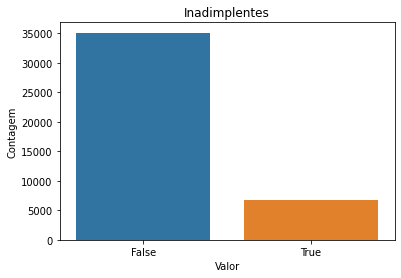

Proporção entre Inadimplentes no Dataset:
False    0.779556
True     0.148022
Name: target_default, dtype: float64


In [9]:
# Proporção entre Inadimplentes no Dataset
fig, ax = plt.subplots()
sns.countplot('target_default', data=df, ax=ax)
ax.set_title("Inadimplentes")
ax.set_xlabel("Valor")
ax.set_ylabel("Contagem")
plt.show()

print("Proporção entre Inadimplentes no Dataset:")
print(df['target_default'].value_counts() / df.shape[0])

A variável principal da análise é composta majoritariamente de `False`, o que vai acarretar em viés, desse modo, para treinar o modelo de Machine Learning, será necessário balancear esses dados a fim de se obter um melhor resultado.

## Preparação dos Dados

Com as informações que obtivemos da etapa anterior, vamos prosseguir com a limpeza e preparação dos dados.

Para a primeira parte da preparação iremos:
* Excluir colunas que não serão usadas.
* Substituir valores errados por nulo
* Excluir entradas com valores nulos para `target_default`.
* Por último, substituir os valores nulos.

In [10]:
# PREPARAÇÃO DOS DADOS
df_clean = df.copy()

# substituir inf por nan em reported_income 
df_clean['reported_income'] = df_clean['reported_income'].replace(np.inf,
                                                                  np.nan)

# descartar as colunas ids, target_fraud, external_data_provider_credit_checks_last_2_year e channel
df_clean.drop(labels=['ids', 'target_fraud',
                      'external_data_provider_credit_checks_last_2_year',
                      'channel'], axis=1, inplace=True)

#  substituir -999 em external_data_provider_email_seen_before por NaN
df_clean.loc[df_clean['external_data_provider_email_seen_before'] == -999.0,
             'external_data_provider_email_seen_before'] = np.nan

# elminar colunas sem informação aparente ou que demandam mais pesquisa
drop_var = ['reason', 'zip', 'job_name', 'external_data_provider_first_name',
            'lat_lon', 'shipping_zip_code', 'user_agent', 'profile_tags',
            'application_time_applied', 'email', 'marketing_channel',
            'profile_phone_number', 'shipping_state']
df_clean.drop(labels=drop_var, axis=1, inplace=True)

# elminar as entradas onde target_default é NaN
df_clean.dropna(subset=['target_default'], inplace=True)
df_clean.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,state,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
0,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,444,2,0.0,51.0,645,57849.0
1,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,346,1,0.0,17.0,243,4902.0
2,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,6,2,NaN,9.0,65,163679.0
3,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,406,3,NaN,38.0,815,1086.0
4,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,240,2,1.0,46.0,320,198618.0


Acima podemos ver novamente como o **Dataset** ficou apois essa preparação inicial.

Apesar de não haver maiores informações sobre as *features*, podemos assumir como premissa que muitos valores são nulos devido a dois fatores:

1. Há alguns itens que não são obrigatórios durante a etapa de preenchimento dos formulários, como a informação sobre o perfil do cliente no Facebook
2. Não existe observação alguma referente à coluna, como é caso das colunas `['last_amount_borrowed', 'last_borrowed_in_months', 'n_issues']`.

De maneira geral, para as variáveis que se enquadram no segundo caso, os valores `NaN` serão substituidos por zero. Para as variáveis numéricas, será adotado o valor da mediana, e para as categóricas o valor mais frequente.

In [11]:
from sklearn.impute import SimpleImputer

num_df = df_clean.select_dtypes(exclude='object').columns
cat_df = df_clean.select_dtypes(include='object').columns

# substituição de valores ausentes por 0
df_clean.last_amount_borrowed.fillna(value=0, inplace=True)
df_clean.last_borrowed_in_months.fillna(value=0, inplace=True)
df_clean.n_issues.fillna(value=0, inplace=True)

# substituição de variáveis numéricas pela mediana
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_clean.loc[:,num_df])
df_clean.loc[:,num_df] = imputer.transform(df_clean.loc[:,num_df])

# substituição de variáveis categóricas pelo mais frequente
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_clean.loc[:,cat_df])
df_clean.loc[:,cat_df] = imputer.transform(df_clean.loc[:,cat_df])
df_clean.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,state,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
0,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,N5/CE7lSkAfB04hVFFwllw==,32.0,0.0,0.0,18.0,18.0,444.0,2.0,0.0,51.0,645.0,57849.0
1,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,0.00,0.0,39726.0,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,346.0,1.0,0.0,17.0,243.0,4902.0
2,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,25213.0,65023.65,False,Ygq6MsM98oC8yceExr69Ig==,n+xK9CfX0bCn77lClTWviw==,32.0,0.0,0.0,10.0,0.0,6.0,2.0,1.0,9.0,65.0,163679.0
3,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,0.00,0.0,54591.0,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,n+xK9CfX0bCn77lClTWviw==,32.0,1.0,0.0,19.0,19.0,406.0,3.0,1.0,38.0,815.0,1086.0
4,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,0.00,0.0,25213.0,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,n+xK9CfX0bCn77lClTWviw==,32.0,0.0,0.0,11.0,0.0,240.0,2.0,1.0,46.0,320.0,198618.0


**Valores ausentes**

Podemos agora verificar que as variáveis escolhidas não possuem mais os valores nulos iniciais.

In [12]:
# verificar a quantidade de dados nulos
df_clean.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
income                                             0
facebook_profile                                   0
state                                              0
real_state                                         0
ok_since                                           0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                    

Para finalizar essa parte de *Preparação dos dados*, falta modificar o Banco de Dados de um modo que o modelo de Machine Learning possa funcionar de maneira melhor, isso significa que vou precisar:

* Transformar as features que continham 2 labels únicos, elas se tornarão em valores 0 e 1.
* Transformas as variáveis categóricas em variáveis dummy, para permitir a sua utilização.

In [13]:
# pré processar as variáveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# criar uma cópia do dataframe
df_proc = df_clean.copy()

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding para colunas categóricas com múltiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,facebook_profile,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,score_1_1Rk8w4Ucd5yR3KcqZzLdow==,score_1_4DLlLW62jReXaqbPaHp1vQ==,score_1_8k8UDR4Yx0qasAjkGrUZLw==,score_1_DGCQep2AE5QRkNCshIAlFQ==,score_1_e4NYDor1NOw6XKGE60AWFw==,score_1_fyrlulOiZ+5hoFqLa6UbDQ==,score_1_smzX0nxh5QlePvtVf6EAeg==,score_2_+2hzpeP1RWr8PEvL1WTUdw==,score_2_+CxEO4w7jv3QPI/BQbyqAA==,score_2_/tdlnWjXoZ3OjdtBXzdOJQ==,score_2_5/uMrqKj3OL/Xk5OrGx9fg==,score_2_55UK234RR1d7HIWJjmq9tw==,score_2_6J1ZMTzN5GKHXnhM4J1JbA==,score_2_7h+tk4z7O9brtBSe1rNjxA==,score_2_7h8PTkrlTWUPP3yuyP4rUg==,score_2_A+QuW1n/ABeiVVe/9CRZ9Q==,score_2_Fv28Bz0YRTVAT5kl1bAV6g==,score_2_IOVu8au3ISbo6+zmfnYwMg==,...,state_9sS116y/1CqWLVJ8nFOGZg==,state_BB/zpwTH+8GCIVHlhzOU1Q==,state_DLK5rpOxZhCM5oQvfUpkTQ==,state_E8shyM/6btBNXXExsO17zw==,state_GFOaXqGcKJxSSF9aBDDNaA==,state_GW2VZ3dN3OGHSjQ6JkfqQw==,state_Jc0dzuliQSKFl0Xy0bjYCQ==,state_JrdZzPZEa/YIIGwh8OdTKA==,state_KET/Pmr6rHp1RJ/P9ymztw==,state_LXZkF0tV1Ma9JIlIvaUDiw==,state_NX0S6z5x5fEStwXfBQN5FQ==,state_OCoEDgPLpDjHcbEmPpAjvA==,state_P1TKs1aii8osbgO+MszZ2w==,state_QCVqG0wT4xPLQuiTIExO2w==,state_QMl/wADluYmoYZIXDOUktQ==,state_TYC58USu+Tq7c/WS4YLnuQ==,state_VafbDA6D5W2TpGMAUJbW8Q==,state_Ygq6MsM98oC8yceExr69Ig==,state_ZUmHOp1/xBWh5O/uqDutsw==,state_ZVfsutsd1Go0zZEnGp0vEA==,state_bNDXnbe7XAx/VUe+cbjDiw==,state_bwNrC22VlFOFk6/nEHQc6A==,state_cd+7k16vaf6SzwSyvT/fHw==,state_fMOpZ7DFhwQgTxW547UMCQ==,state_fR2lwAMjCb/fNXjsApiOTw==,state_kfFcVGcsJmH2n3eYprLkeQ==,state_orU7WJYGPT/xFwOXY1eBkw==,state_qItmSqWrjm+MopDA+UpKRw==,state_rrVbgRNTRyB6auEycsRrpA==,state_sjJbkqJS7cXalHLBFA+EOQ==,state_umkEte5GXWggFkMOtKQ3Ug==,state_x6Gw/1I8t3KPgT6s82Kodg==,state_xsd3ZdsI3356I3xMxZeiqQ==,state_ygE7OTdsxRMLeXMa0EZwZw==,state_yni6lL4oSly97UVZeRSyxA==,real_state_+qWF9pJpVGtTFn4vFjb/cg==,real_state_N5/CE7lSkAfB04hVFFwllw==,real_state_UX7AdFYgQh+VrVC5eIaU9w==,real_state_n+xK9CfX0bCn77lClTWviw==,real_state_nSpvDsIsslUaX6GE6m6eQA==
0,0,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,1,32.0,0.0,0.0,18.0,18.0,444.0,2.0,0,51.0,645.0,57849.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,0,370.0,97.062615,0.942655,92.002546,0.24,0.00,0.0,39726.0,100018.91,0,50.0,0.0,0.0,14.0,14.0,346.0,1.0,0,17.0,243.0,4902.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,1,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,25213.0,65023.65,0,32.0,0.0,0.0,10.0,0.0,6.0,2.0,1,9.0,65.0,163679.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,510.0,101.599485,0.987673,94.902491,0.32,0.00,0.0,54591.0,68830.01,0,32.0,1.0,0.0,19.0,19.0,406.0,3.0,1,38.0,815.0,1086.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,500.0,98.474289,0.532539,118.126207,0.18,0.00,0.0,25213.0,60011.29,1,32.0,0.0,0.0,11.0,0.0,240.0,2.0,1,46.0,320.0,198618.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


Com esse **Dataset**, muito mais limpo, que começarei a próxima etapa.

## Machine Learning

**Divisão dos dados**

Com o processamento realizado na etapa anterior, os dados já podem ser usados nos modelos de machine learning.

Para podermos comparar o desempenho e melhora do modelo, usarei um algoritmo simples. Não será feito nenhum ajuste nos hiperparâmetros e nem será pensado ainda em balanceamento de dados.

No entanto, é importante separar os dados que serão utilizados como treino e teste. Os dados de teste só irão ser usados na última etapa do projeto, para termos uma avaliação mais real

In [14]:
# separar a feature matrix da target vector
X = df_proc.drop('target_default', axis=1)
y = df_proc['target_default']

# dividir os dados entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

**Validação Cruzada**

Agora, irei criar uma função, que dei o nome val_model. Essa função, ao dar os inputs X_train, y_train e o modelo de machine learning, ela vai fazer uma validação cruzada, ou seja, vai dividir esses dados de 5 formas diferentes e ver o resultado do modelo com cada uma dessas 5 divisões diferentes.

O objetivo disso é ter uma média da assertividade do modelo com varios dados diferentes, assim, aumentando a nossa confiança com o modelo.

In [15]:
# Criação da função val_model
def val_model(X, y, clf, show=True):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

Agora, irei testar a função acima com um modelo de `Random Forest`, sem nenhum tipo de alteração nos parâmetros e sem balancear os dados.

In [16]:
# Testando a função com um Algoritmo de Classificação
rf = RandomForestClassifier()
score_inicial = val_model(X_train, y_train, rf)

Recall: 0.02 (+/- 0.01)


Acima podemos ver que nosso modelo teve uma média de 0.02 (2%) de recall, que é uma medida de assertividade.

O recall nos informa uma porcentagem que mede quantos target_default=1 o modelo acertou, de todos os 1 que aconteceram.

Uma vez que temos um baseline para comparar se os ajustes melhoram ou pioram o desempenho do modelo, irei realizar o balanceamento dos dados e ver como isso irá impactar.

A técnica escolhida foi Under Sampling. Seguindo recomendações de algumas literaturas, os dados serão padronizados antes de usar essa técnica de balanceamento.

Lembrando, é importante que o balanceamento aconteca apenas com os dados de treino. Os dados de teste devem permanecer intocáveis.

In [17]:
# Padronizar os Dados
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Balancear os Dados de Treino
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

Agora, aplicarei a validação cruzada com vários modelos para podermos escolher um para seguir o projeto, desta vez, os dados estão balanceados e já vai haver uma mudança significativa em comparação com a nota passada.

Os modelos escolhidos são:

- Random Forest
- Decision Tree
- Stochastic Gradient Descent
- SVC
- Regressão Logística
- XG Boost
- LightGBM

In [18]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, show=False))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.647313
DecisionTreeClassifier,0.563049
SGDClassifier,0.626498
SVC,0.642511
LogisticRegression,0.656721
XGBClassifier,0.658723
LGBMClassifier,0.642314


Podemos ver que após balancear os dados, o recall com `Random Forest` subiu para 64%

Dadas as notas, os modelos acima e as possibilidades de tuning de parâmetros, optei por continuar o projeto com o `XGBClassifier`.

## Otimização de Hiperparâmetros

XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos.

Abaixo irei fazer o que é chamado de **Grid Search.** Nada mais é do que dar uma lista com vários valores de certos parâmetros, a partir daí o GridSearchCV vai testar o modelo com esses vários parâmetros e então usaremos o parâmetro com melhor resultado.

Assim como eu fiz acima, onde avaliei vários modelos e continuei com XGBoost, agora isso será feito com diferentes parâmetros, para escolher o melhor a ser usado no modelo final.

Usarei Grid Search nos seguintes parâmetros:

- learning_rate
- gamma
- max_depth
- n_estimators


In [19]:
# instanciando o modelo
xgb = XGBClassifier()

# definindo os parâmetros a serem testados
param_grid = {
  'learning_rate': [0.001, 0.01, 0.1],  
  'gamma':[0, 1, 5],
  'max_depth': [1, 3, 5],
  'n_estimators': [100, 500, 1000],
 }

# identificar melhores parâmetros
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {:.2f} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.82 para {'gamma': 0, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100}


**Resultado do Grid Search**

Como mostrado acima, com gamma = 0, learning_rate = 0.001, max_depth = 3 e n_estimators = 100 chegamos a um recall de 82%, antes o modelo tinha assertividade de apenas 2%.

Agora, com hiperparâmetros escolhidos, finalmente iremos treinar o modelo final e usar com os dados de teste, que estavam intocados até agora.

In [20]:
# MODELO FINAL
xgb = XGBClassifier(gamma=0, learning_rate=0.001, max_depth=3, n_estimators=100)
xgb.fit(X_train_rus, y_train_rus)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [21]:
# Previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

**Resultado Final**

              precision    recall  f1-score   support

           0       0.92      0.43      0.58      8771
           1       0.21      0.81      0.34      1665

    accuracy                           0.49     10436
   macro avg       0.57      0.62      0.46     10436
weighted avg       0.81      0.49      0.54     10436

AUC: 0.6191



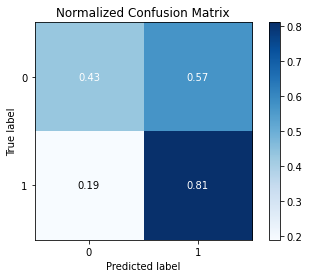

In [22]:
# Classification Report
print(classification_report(y_test, y_pred, digits=2))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

Acima, podemos ver na tabela de classificação que alcançamos um recall de aproximadamente 81% com os dados de teste.

Por que dei tanta ênfase ao recall e não a outras medidas de nota para o modelo? Simples, é o recall que mede o número de acertos de default sobre todos os casos de default, isso quer dizer que um recall baixo significa um alto número de inadimplência que o modelo não preveu. E é exatamente o contrario disso que queremos, ou seja, um modelo que prevê inadimplência por parte dos clientes.

## Conclusões

Os dados de testes não haviam sido passados para o modelo ainda. No entanto, ele manteve um desempenho próximo àquele estimado anteriormente, graças a um bom trabalho de otimização nos parâmetros.

Ainda há espaço para se tentar outras técnicas de balanceamento de dados e também técnicas de machine learning como feature engineering.

Espero que tenham gostado do projeto!